# Image Classification
<p><a href="https://gitlab.ec-lyon.fr/edelland/mod_4_6-td1">Ennoncé</a>.</p>

## Introduction
<p>Le but de ce TD est d'appliquer les méthodes de classification vues en cours. Pour cela nous travaillerons sur la base de donnée CIFAR-10 sur laquelle nous appliquerons d'abord la classification par k-plus proches voisins avec une distance euclidienne puis nous utiliserons une classification par réseaux de neuronne.
Pour chacune de ces méthodes nous regarderons le taux de réussite.</p>

## Importation des données

In [32]:
import numpy as np
import pickle
import os

In [33]:
def read_cifar_batch(batch_path):
    with open(batch_path, 'rb') as file:
        batch_data = pickle.load(file, encoding='bytes')
    data = np.array(batch_data[b'data'], dtype=np.float32)
    labels = np.array(batch_data[b'labels'], dtype=np.int64)
    return data, labels

In [34]:
def read_cifar(path_folder):
    data = np.empty((0, 3072), dtype=np.float32)
    labels = np.empty((0), dtype=np.int64)
    for filename in os.listdir(path_folder):
        if filename.startswith("data_batch") or filename == "test_batch":
            batch_path = os.path.join(path_folder, filename)
            d, l = read_cifar_batch(batch_path)
            data = np.concatenate((data, d), axis=0)
            labels = np.concatenate((labels, l), axis=None)
    return(data,labels)

In [35]:
def split_dataset(data, labels, split_factor):
    num_samples = len(data)
    shuffled_indices = np.random.permutation(num_samples)
    split_index = int(num_samples * split_factor)

    data_train = data[shuffled_indices[:split_index],:]
    labels_train = labels[shuffled_indices[:split_index]]
    data_test = data[shuffled_indices[split_index:],:]
    labels_test = labels[shuffled_indices[split_index:]]

    return data_train, labels_train, data_test, labels_test

In [37]:
if __name__ == "__main__":
    #read_cifar_batch("data/cifar-10-batches-py/data_batch_1")
    d, l = read_cifar("data/cifar-10-batches-py")
    print(l[0:10])
    d_1, l_1, d_2, l_2 = split_dataset(d[:10,:], l[:10], 0.9)
    print(l_1,l_2)
    d_1, l_1, d_2, l_2 = split_dataset(d[:10,:], l[:10], 0.9)
    print(l_1,l_2)

[6 9 9 4 1 1 2 7 8 3]
[9 6 7 4 8 1 3 1 9] [2]


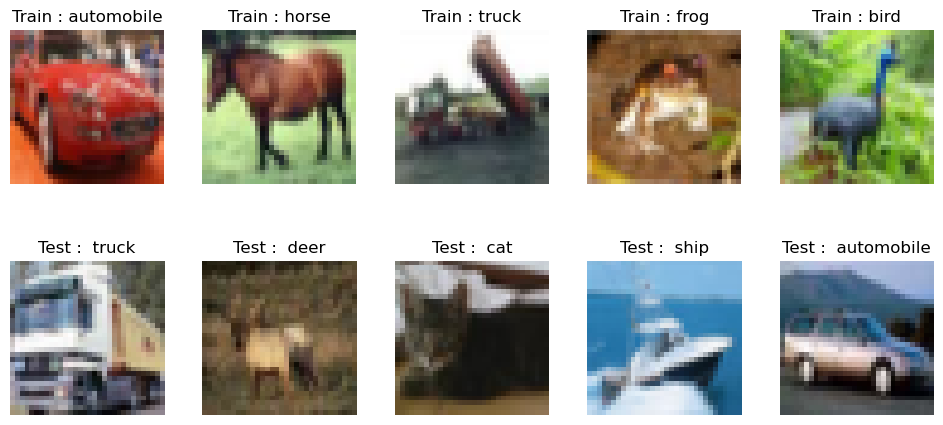

In [38]:
import matplotlib.pyplot as plt

def affichage(d_train, l_train, d_test, l_test):
    long, large = 5,2

    with open("data/cifar-10-batches-py/batches.meta", 'rb') as file:
        batch_data = pickle.load(file, encoding='bytes')
    liste_names= np.array(batch_data[b'label_names'])
    fig, axes = plt.subplots(large, long, figsize=(12, 5))
    fig.subplots_adjust(hspace=0.5)
    for i in range(len(l_train)):
        im = np.array(np.reshape(d_train[i, 0:3072], (32, 32, 3), order='F'), dtype=np.int64)
        im = np.transpose(im, (1, 0, 2))
        name=liste_names[l_train[i]]
        axes[i // long, i % long].imshow(im)
        axes[i // long, i % long].set_title(f"Train : {name.decode('utf-8')}")
        axes[i // long, i % long].axis('off')
    for i in range(len(l_test)):
        im = np.array(np.reshape(d_test[i, 0:3072], (32, 32, 3), order='F'), dtype=np.int64)
        im = np.transpose(im, (1, 0, 2))
        j = i + len(l_train)
        name=liste_names[l_test[i]]
        axes[j // long, j % long].imshow(im)
        axes[j // long, j % long].set_title(f"Test :  {name.decode('utf-8')}")
        axes[j // long, j % long].axis('off')    
    plt.show()

if __name__ == "__main__":
    d, l = read_cifar("data/cifar-10-batches-py")
    d_1, l_1, d_2, l_2 = split_dataset(d[:10,:], l[:10], 0.5)
    affichage(d_1, l_1, d_2, l_2)

In [39]:
def distance_matrix(data_train, data_test):
    dist_mat=[]
    for image_test in data_test:
        dist_mat.append([])
        for image_train in data_train:
            dist_mat[-1].append(np.sum(np.square(image_train-image_test)))
    return(np.array(dist_mat))

In [40]:
def knn_predict(dist, labels_train, k):
    resultat=[]
    for image_test in dist:
        k_max = np.argpartition(image_test, k)[:k]
        val, count = np.unique(labels_train[k_max], return_counts=True)
        indexe = np.argmax(count)
        resultat.append(val[indexe])
    return (resultat)

In [41]:
def evaluate_knn(data_train, labels_train, data_test, labels_test, k):
    dist_matrice = distance_matrix(data_train, data_test)
    res = knn_predict(dist_matrice, labels_train, k)
    return(np.sum(labels_test == res) / len(labels_test))

In [42]:
if __name__ == "__main__":
    x = range(1, 20)
    d, l = read_cifar_batch("data/cifar-10-batches-py/data_batch_1")
    d_train, l_train, d_test, l_test = split_dataset(d, l, 0.9)
    dist_matrice = distance_matrix(d_train, d_test)
    y = []
    for knn in x:
        stat = 0
        res = knn_predict(dist_matrice, l_train, knn)
        y.append(np.sum(l_test == res) / len(l_test))
    plt.plot(x, y, label='Précision')
    plt.xlabel('nombre de plus proche voisins concidérés')
    plt.ylabel('taux de bonne calification')
    plt.xticks(range(1, 20))  # Afficher des valeurs entières sur l'axe des abscisses
    plt.legend()
    plt.show()

KeyboardInterrupt: 